In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../new_modules')
import ObsModels

import FSC as controller

In [3]:
import torch

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

In [4]:
NStepsObs = 100
NTraj = 100
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(100, 100)

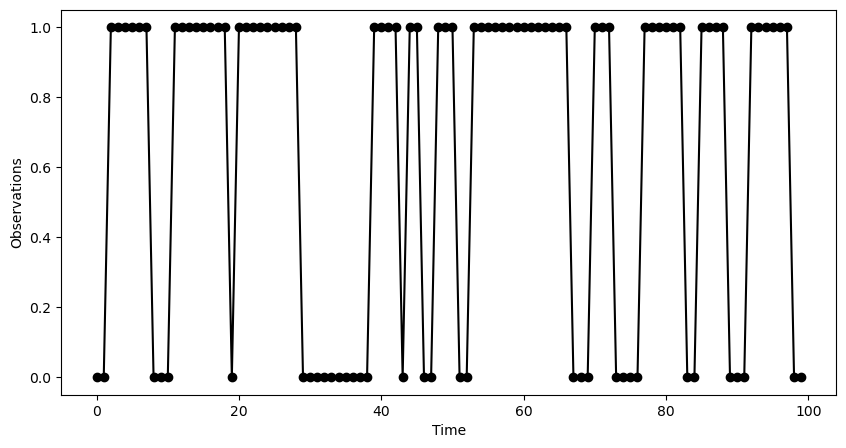

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [6]:
ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])


FSC = controller.FSC("discrete", M = 2, A = 2, Y = Y, mode = "generation", seed = 42,
                     psi = Psi, theta = ThetaFollowSwitch)

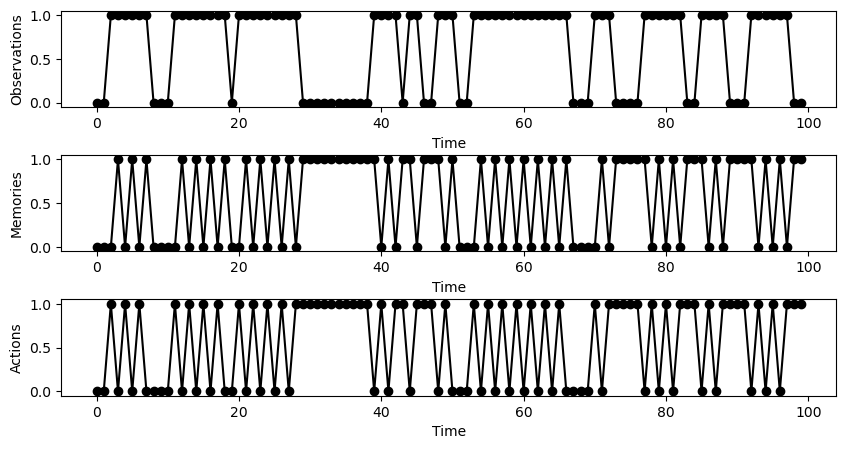

In [7]:
FSC.generator.load_observations(observations)

NSteps = NStepsObs
trajectories = FSC.generator.generate_trajectories(NSteps)

idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.generator.plot_trajectory(trj)

In [9]:
nLL = 0

for trj in trajectories:
    nLL += FSC.generator.evaluate_nloglikelihood(trj)

nLL/len(trajectories)

0.6798947151326453

## Inference

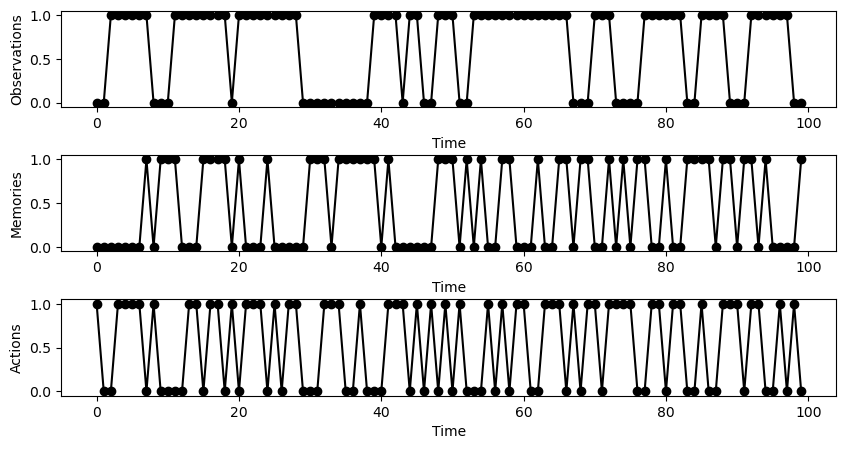

In [10]:
FSC_tofit = controller.FSC("discrete", M = 2, A = 2, Y = Y, mode = "generation", seed = 42)
FSC_tofit.generator.load_observations(observations)

NSteps = NStepsObs
trj = FSC_tofit.generator.generate_single_trajectory(NSteps, idx_observation = 0)

fig, ax = FSC_tofit.generator.plot_trajectory(trj)

In [58]:
FSC_tofit.set_mode("inference")
FSC_tofit.inferencer.load_trajectories(trajectories)

In [59]:
nLL = torch.tensor(0.0, device = FSC_tofit.inferencer.device)

for idx_traj in range(len(trajectories)):
    nLL += FSC_tofit.inferencer.evaluate_nloglikelihood(idx_traj = idx_traj)

nLL/len(trajectories)

tensor(68.9905, device='mps:0', grad_fn=<DivBackward0>)

In [61]:
%%time
tloss, vloss = FSC_tofit.inferencer.optimize(NEpochs = 10, NBatch = 20, lr = 0.2, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 66.57420349121094, Validation loss: 66.00489940643311 - Learning rate: 0.2
Epoch 2 - Training loss: 54.11705017089844, Validation loss: 50.49224491119385 - Learning rate: 0.18000000000000002
Epoch 3 - Training loss: 35.213854980468746, Validation loss: 29.830932712554933 - Learning rate: 0.16200000000000003
Epoch 4 - Training loss: 17.89696178436279, Validation loss: 13.935795021057128 - Learning rate: 0.14580000000000004
Epoch 5 - Training loss: 8.086406230926514, Validation loss: 6.477579021453858 - Learning rate: 0.13122000000000003
Epoch 6 - Training loss: 4.045452117919922, Validation loss: 3.6665092945098876 - Learning rate: 0.11809800000000004
Epoch 7 - Training loss: 2.48974928855896, Validation loss: 2.5616954267024994 - Learning rate: 0.10628820000000004
Epoch 8 - Training loss: 1.8368119716644287, Validation loss: 2.0680411636829374 - Learning rate: 0.09565938000000004
Epoch 9 - Train

# Finite State Controller with custom $M = 2$, $A = 2$, $Y = 2$

In [69]:
ObsSpace = np.array(["Obs 0", "Obs 1"])
ActSpace = np.array(["Act 0", "Act 1"])
MemSpace = np.array(["Mem 0", "Mem 1"])

M = len(MemSpace)
A = len(ActSpace)

In [70]:
NStepsObs = 100
NTraj = 100
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
# convert observations to strings
observations = [ObsSpace[o] for o in observations]

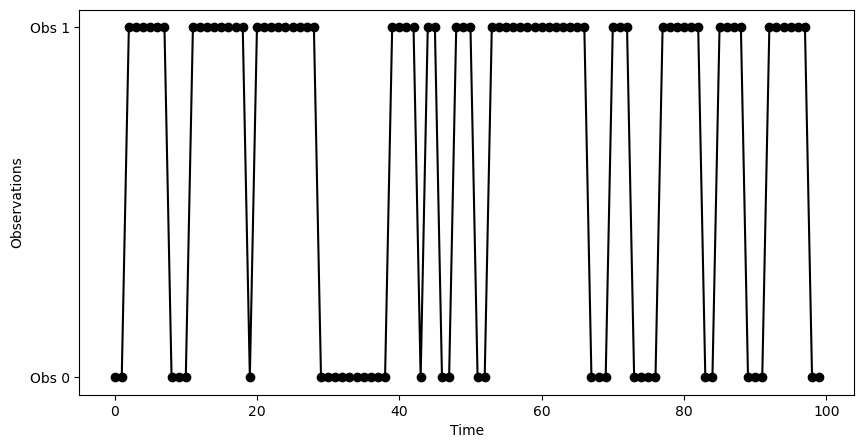

In [73]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [77]:
ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])


FSC = controller.FSC("discrete", M = M, A = A, Y = Y, mode = "generation",
                     ObsSpace = ObsSpace, ActSpace = ActSpace, MemSpace = MemSpace,
                     psi = Psi, theta = ThetaFollowSwitch, seed = 42)

FSC.generator.load_observations(observations)

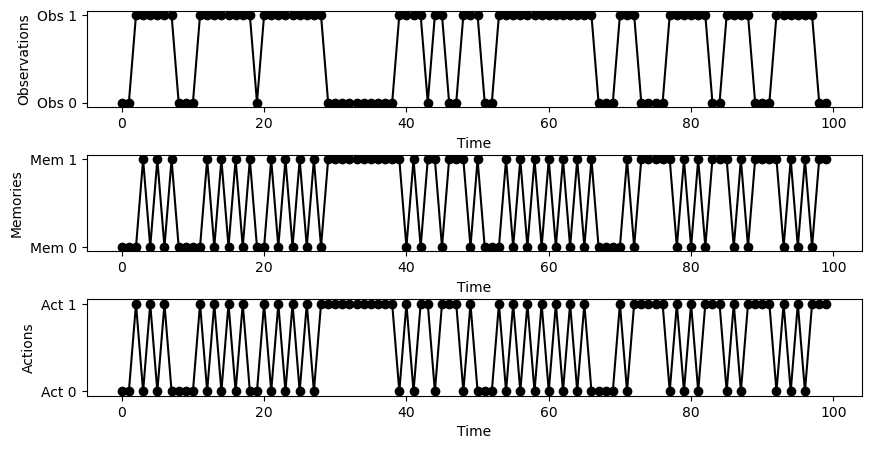

In [80]:
FSC.generator.load_observations(observations)

trajectories = FSC.generator.generate_trajectories(NSteps)

idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.generator.plot_trajectory(trj)

In [81]:
nLL = 0

for trj in trajectories:
    nLL += FSC.generator.evaluate_nloglikelihood(trj)

nLL/len(trajectories)

0.772862784796525

## Inference

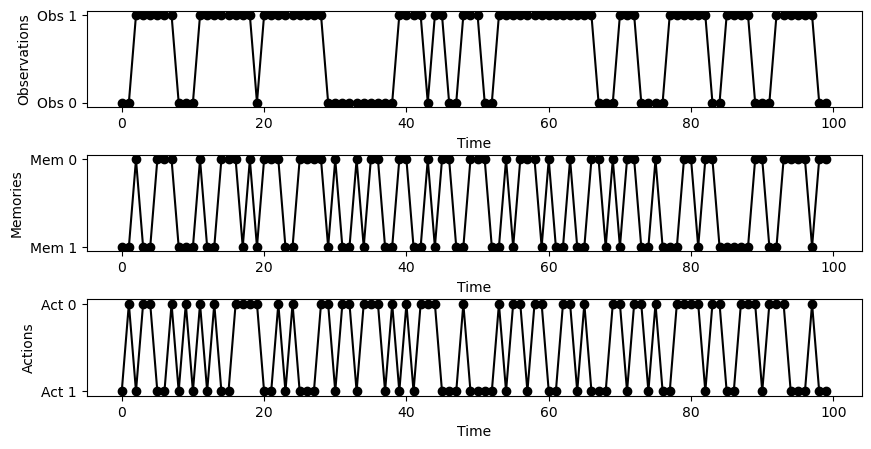

In [88]:
FSC_tofit = controller.FSC("discrete", M = 2, A = 2, Y = Y, mode = "generation", seed = 42,
                            ObsSpace = ObsSpace, ActSpace = ActSpace, MemSpace = MemSpace)
FSC_tofit.generator.load_observations(observations)

NSteps = NStepsObs
trj = FSC_tofit.generator.generate_single_trajectory(NSteps, idx_observation = 0)

fig, ax = FSC_tofit.generator.plot_trajectory(trj)

In [89]:
FSC_tofit.set_mode("inference")
FSC_tofit.inferencer.load_trajectories(trajectories)

In [90]:
nLL = torch.tensor(0.0, device = FSC_tofit.inferencer.device)

for idx_traj in range(len(trajectories)):
    nLL += FSC_tofit.inferencer.evaluate_nloglikelihood(idx_traj = idx_traj)

nLL/len(trajectories)

tensor(69.3952, device='mps:0', grad_fn=<DivBackward0>)

In [91]:
%%time
tloss, vloss = FSC_tofit.inferencer.optimize(NEpochs = 10, NBatch = 20, lr = 0.2, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 66.28145904541016, Validation loss: 61.73664817810059 - Learning rate: 0.2
Epoch 2 - Training loss: 51.30232696533203, Validation loss: 42.57518978118897 - Learning rate: 0.18000000000000002
Epoch 3 - Training loss: 29.080861663818357, Validation loss: 21.563582468032838 - Learning rate: 0.16200000000000003
Epoch 4 - Training loss: 13.314150238037108, Validation loss: 9.657690238952636 - Learning rate: 0.14580000000000004
Epoch 5 - Training loss: 6.0315542221069345, Validation loss: 4.784083926677704 - Learning rate: 0.13122000000000003
Epoch 6 - Training loss: 3.2621185779571538, Validation loss: 2.9514553368091585 - Learning rate: 0.11809800000000004
Epoch 7 - Training loss: 2.176986026763916, Validation loss: 2.19629328250885 - Learning rate: 0.10628820000000004
Epoch 8 - Training loss: 1.6842470645904541, Validation loss: 1.8455076575279237 - Learning rate: 0.09565938000000004
Epoch 9 - Trai

In [95]:
FSC_tofit.inferencer.rho, FSC_tofit.inferencer.TMat

(tensor([0.2587, 0.7413], device='mps:0'),
 tensor([[[[9.8866e-01, 1.6806e-03],
           [6.7861e-03, 2.8775e-03]],
 
          [[5.4017e-03, 1.2876e-03],
           [1.7944e-03, 9.9152e-01]]],
 
 
         [[[1.7123e-03, 2.5996e-03],
           [1.1953e-03, 9.9449e-01]],
 
          [[9.9885e-01, 1.9558e-04],
           [1.9181e-04, 7.6538e-04]]]], device='mps:0', grad_fn=<DivBackward0>))

In [98]:
FSC.generator.rho, FSC.generator.TMat

(array([0.26894142, 0.73105858]),
 array([[[[9.99862450e-01, 4.58498991e-05],
          [4.58498991e-05, 4.58498991e-05]],
 
         [[4.58498991e-05, 4.58498991e-05],
          [4.58498991e-05, 9.99862450e-01]]],
 
 
        [[[4.58498991e-05, 4.58498991e-05],
          [4.58498991e-05, 9.99862450e-01]],
 
         [[9.99862450e-01, 4.58498991e-05],
          [4.58498991e-05, 4.58498991e-05]]]]))